In [1]:
# Personalized Learning Model for Neurodivergent Students 
# Clustering

# Carly Carroll

In [2]:
##### LOAD LIBRARIES ##### 

import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
import numpy as np

In [3]:
##### LOAD CSV FILE #####

engagement_profile = pd.read_csv("engagement_profile_clean.csv")

In [4]:
##### FEATURE SELECTION #####

features = [
    'id_student',
    'sum_click', 
    'studied_credits', 
    'num_of_prev_attempts',
    'score', 
    'imd_band', 
    'age_band'
]

# drop NA and encode categorical features
df_clean = engagement_profile[features].dropna()

# one hot encode categorical variables
df_encoded = pd.get_dummies(df_clean, drop_first=True)

# sample the data to avoid memory crashes
df_sampled = df_encoded.sample(n=10000, random_state=42)

In [5]:
##### FEATURE SCALING #####

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_sampled)

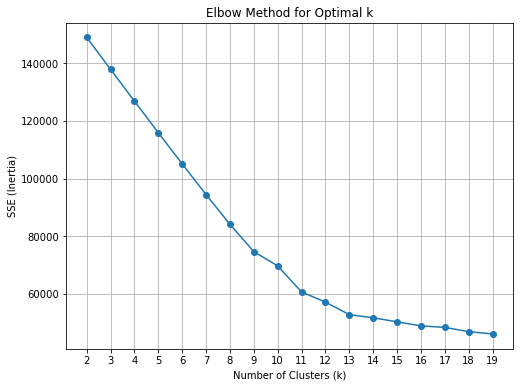

In [6]:
##### ELBOW METHOD FOR OPTIMAL K #####

# try a range of cluster values
sse = []
k_range = range(2, 20)

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    sse.append(km.inertia_) 

# plot the elbow curve
plt.figure(figsize=(8, 6))
plt.plot(k_range, sse, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('SSE (Inertia)')
plt.title('Elbow Method for Optimal k')
plt.xticks(k_range)
plt.grid(True)
plt.show()

In [7]:
##### SILHOUETTE SCORE FOR OPTIMAL K #####

for k in range(2, 20):
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    print(f"k = {k} → Silhouette Score: {score:.4f}")

k = 2 → Silhouette Score: 0.0964
k = 3 → Silhouette Score: 0.1392
k = 4 → Silhouette Score: 0.1880
k = 5 → Silhouette Score: 0.2348
k = 6 → Silhouette Score: 0.2806
k = 7 → Silhouette Score: 0.3232
k = 8 → Silhouette Score: 0.3604
k = 9 → Silhouette Score: 0.3852
k = 10 → Silhouette Score: 0.3447
k = 11 → Silhouette Score: 0.3664
k = 12 → Silhouette Score: 0.3639
k = 13 → Silhouette Score: 0.3689
k = 14 → Silhouette Score: 0.3608
k = 15 → Silhouette Score: 0.3644
k = 16 → Silhouette Score: 0.3611
k = 17 → Silhouette Score: 0.3491
k = 18 → Silhouette Score: 0.3540
k = 19 → Silhouette Score: 0.3453


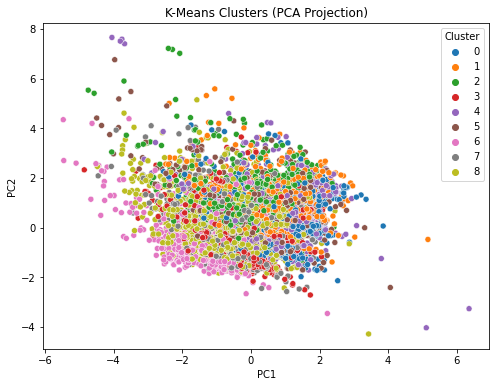

In [8]:
##### DIMENSIONALITY REDUCTION #####

### principal component analysis ###

# run k-means again 
kmeans = KMeans(n_clusters=9, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

# reduce to 2 principal components for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# plot the clusters from k-means
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=kmeans_labels, palette='tab10', legend='full')
plt.title("K-Means Clusters (PCA Projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster")
plt.show()

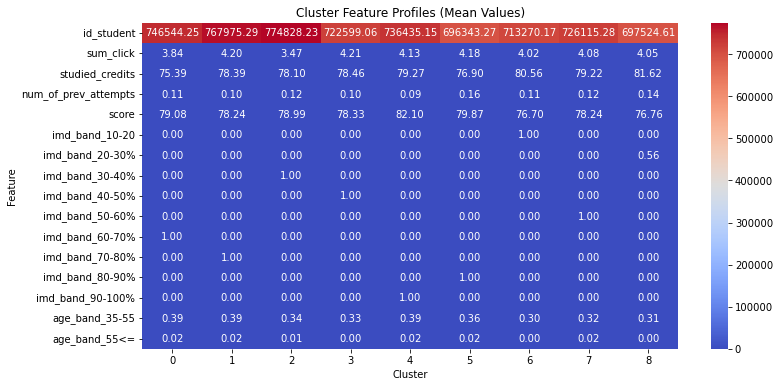

In [9]:
##### PROFILE EACH CLUSTER #####

# attach cluster labels to df_sampled
df_sampled['cluster'] = kmeans_labels

# summary statistics by cluster
cluster_profiles = df_sampled.groupby('cluster').mean()

plt.figure(figsize=(12, 6))
sns.heatmap(cluster_profiles.T, cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Cluster Feature Profiles (Mean Values)")
plt.xlabel("Cluster")
plt.ylabel("Feature")
plt.show()

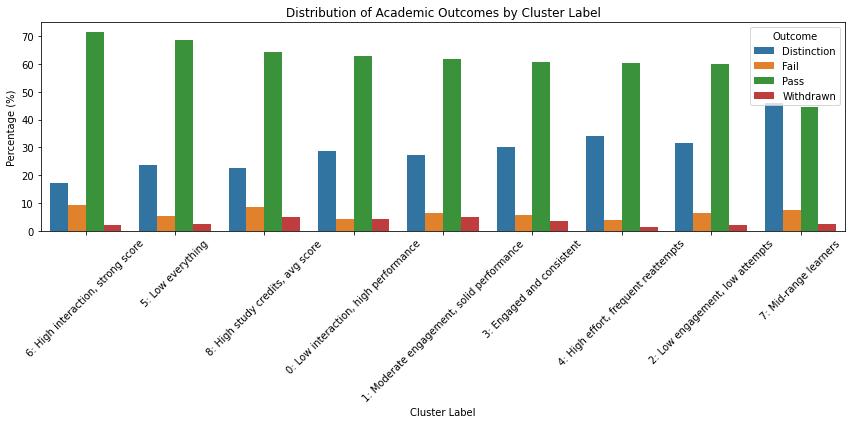

In [10]:
##### EVALUATE CLUSTER COMPOSITION BY OUTCOME ##### 

# cluster labels based on profile interpretation
cluster_labels = {
    0: "0: Low interaction, high performance",
    1: "1: Moderate engagement, solid performance",
    2: "2: Low engagement, low attempts",
    3: "3: Engaged and consistent",
    4: "4: High effort, frequent reattempts",
    5: "5: Low everything",
    6: "6: High interaction, strong score",
    7: "7: Mid-range learners",
    8: "8: High study credits, avg score"
}

# merge original labels for analysis
df_sampled['cluster_label'] = df_sampled['cluster'].map(cluster_labels)
df_sampled = df_sampled.merge(engagement_profile[['id_student', 'final_result']], on='id_student', how='left')

# crosstab of outcome by cluster
outcome_table = pd.crosstab(df_sampled['cluster_label'], df_sampled['final_result'], normalize='index') * 100
outcome_table = outcome_table.round(1).sort_values(by='Pass', ascending=False) 
outcome_table

outcome_table_plot = outcome_table.reset_index().melt(id_vars='cluster_label', 
                                                      var_name='Outcome', 
                                                      value_name='Percentage')

plt.figure(figsize=(12, 6))
sns.barplot(data=outcome_table_plot, x='cluster_label', y='Percentage', hue='Outcome')
plt.title('Distribution of Academic Outcomes by Cluster Label')
plt.xlabel('Cluster Label')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)
plt.legend(title='Outcome')
plt.tight_layout()
plt.show()

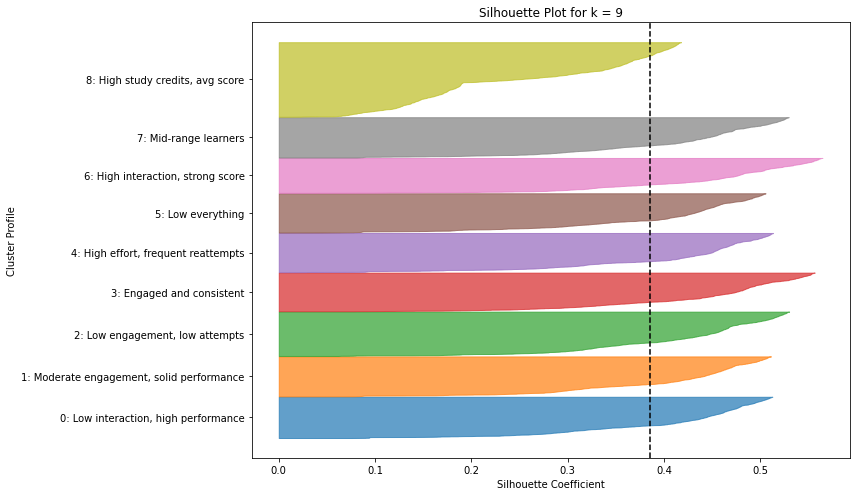

In [11]:
##### SILHOUETTE PLOT #####

sil_vals = silhouette_samples(X_scaled, kmeans_labels)

# generate label names based on clusters
label_names = [cluster_labels[i] for i in sorted(df_sampled['cluster'].unique())]

plt.figure(figsize=(12, 7))
y_lower = 10
yticks = []

for i in sorted(df_sampled['cluster'].unique()):
    ith_sil_vals = sil_vals[kmeans_labels == i]
    ith_sil_vals.sort()
    y_upper = y_lower + len(ith_sil_vals)
    color = plt.cm.tab10(i)
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_sil_vals,
                      facecolor=color, edgecolor=color, alpha=0.7)
    yticks.append((y_lower + y_upper) / 2)
    y_lower = y_upper + 10

plt.axvline(x=sil_vals.mean(), color="black", linestyle="--")
plt.title("Silhouette Plot for k = 9")
plt.xlabel("Silhouette Coefficient")
plt.yticks(yticks, label_names)
plt.ylabel("Cluster Profile")
plt.tight_layout()
plt.show()